<a href="https://colab.research.google.com/github/KimJisanER/MedBioPha/blob/main/heart%20Disease%20Stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 제공된 데이터는 심장병 발병 데이터셋입니다. 변수는 다음과 같습니다.  
### 본인의 판단 하에 전처리와 모델링을 진행하고 성능을 평가해주세요.

1. age : age in years
2. sex : sex (1=male; 0=female)
3. cp : chest pain type
    - Value 1 : typical angina
    - Value 2 : atypical angina
    - Value 3 : non-anginal pain
    - Value 4 : asymptomatic
4. trestbps : resting blood pressure (in mm Hg on admission to the hospital)
5. chol : serum cholestoral in mg/dl
6. fbs : fasting blood sugar > 120 mg/dl (1=true; 0=false)
7. restecg : resting electrocardiographic results
    - Value 0 : normal
    - Value 1 : having ST-T wave abnormally
    - Value 2 : showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach : maximum heart rate achieved
9. exang : exercise induced anggina (1=yes; 0=no)
10. oldpeak : ST depression induced by exercise relative to rest
11. slope : the slope of the peak exercise ST segment
    - Value 1 : upsloping
    - Value 2 : flat
    - Value 3 : downsloping
12. ca : number of major vesses(0-3) colored by flourosopy
13. thal : 3=normal; 6=fixed defect; 7=reversable defect
14. num(target) : diagnosis of heart disease (angiographic disease status)
    - Value 0 : < 50% diameter narrowing
    - Value 1 : > 50% diameter narrowing

### 1. 제공됐던 데이터를 불러와서 파악하고 필요한 전처리를 진행하세요.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# !pip install catboost
import catboost as cb
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import preprocessing
import seaborn as sns

In [ ]:
df=pd.read_csv('data.csv')
df=df.iloc[:,1:]
df.head(5)

,age,sex,cp,treastbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,goal
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        302 non-null    float64
 1   sex        302 non-null    float64
 2   cp         302 non-null    float64
 3   treastbps  302 non-null    float64
 4   chol       302 non-null    float64
 5   fbs        302 non-null    float64
 6   restecg    302 non-null    float64
 7   thalach    302 non-null    float64
 8   exang      302 non-null    float64
 9   oldpeak    302 non-null    float64
 10  slope      302 non-null    float64
 11  ca         298 non-null    float64
 12  thal       300 non-null    float64
 13  goal       302 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.2 KB


In [ ]:
df.isnull().sum()

age          0
sex          0
cp           0
treastbps    0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           4
thal         2
goal         0
dtype: int64

In [ ]:
#결측치 포함한 환자data 제거
df=df.dropna()

In [ ]:
df.goal.value_counts()

0    159
1     54
2     35
3     35
4     13
Name: goal, dtype: int64

goal은 예측 모델의 target으로 Heart Disease의 Stage라고 생각됨.

In [ ]:
df.sex.value_counts()

1.0    200
0.0     96
Name: sex, dtype: int64

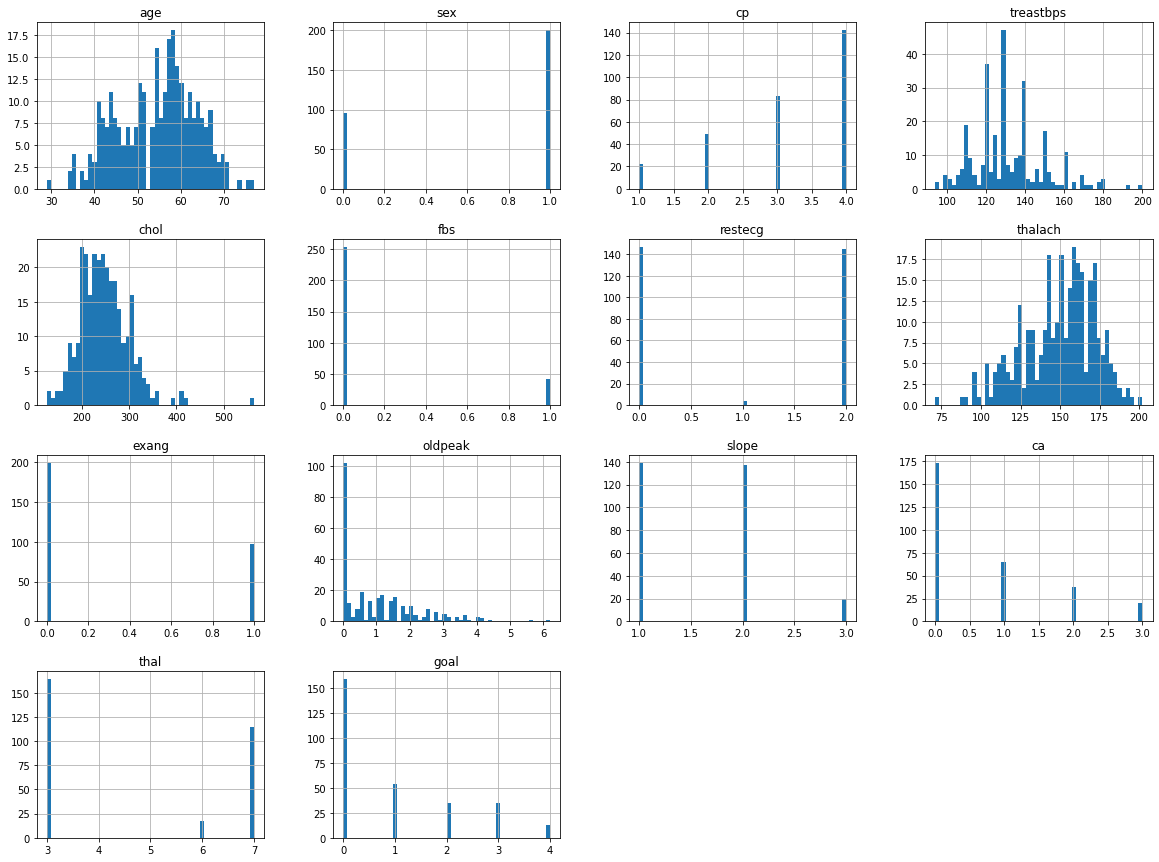

In [ ]:
df.hist(bins=50, figsize=(20,15))
plt.show()

남성의 비중이 높음

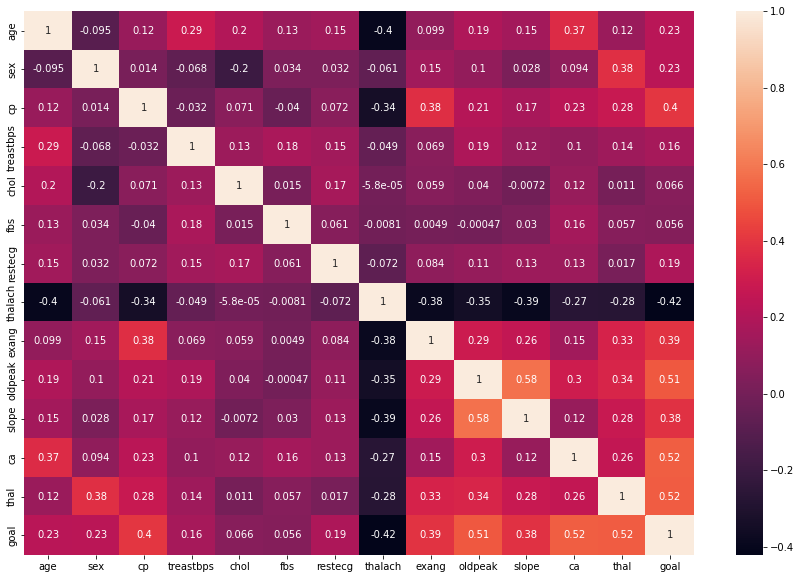

In [ ]:
#변수간 상관관계
plt.figure(figsize=(15,10))
ax = sns.heatmap(df.corr(), annot=True)
plt.show()

In [ ]:
X=df.iloc[:,:-1]
y=df['goal']
print(X.head(1))
print(y.head(1))

    age  sex   cp  treastbps   chol  ...  exang  oldpeak  slope   ca  thal
0  67.0  1.0  4.0      160.0  286.0  ...    1.0      1.5    2.0  3.0   3.0

[1 rows x 13 columns]
0    2
Name: goal, dtype: int64


In [ ]:
#test, validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)
nX_train,nX_val, ny_train, ny_val=train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print(len(nX_train))
print(len(nX_val))

188
48


### 2. 적절한 모델을 선택해 적합하고 성능을 평가해주세요

모델선정

In [ ]:
from catboost.core import CatBoostClassifier
models = []
models.append(('LR',LogisticRegression(solver='liblinear',multi_class = 'ovr')))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC(gamma='auto')))
models.append(('RFC',RandomForestClassifier()))
models.append(('XGBC',XGBClassifier(iterations=10000,verbose=False)))
models.append(('CatBC',CatBoostClassifier(max_depth=4, n_estimators=900, silent=True)))
models.append(('LGBMC',LGBMClassifier()))
models.append(('AdaC',AdaBoostClassifier()))
results =[]
names = []
for name, model in models:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,X_train
                               ,y_train
                               ,cv= kfold,scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

LR : 0.554529 (0.051268) 
LDA : 0.567391 (0.085567) 
KNN : 0.475362 (0.070318) 
CART : 0.470109 (0.089546) 
NB : 0.432609 (0.057862) 
SVM : 0.521377 (0.061380) 
RFC : 0.563225 (0.074687) 
XGBC : 0.538225 (0.062831) 
CatBC : 0.580797 (0.081575) 
LGBMC : 0.567935 (0.043908) 
AdaC : 0.509058 (0.080260) 


성능이 괜찮았던 모델 4가지를 소프트 보팅해서 최종모델을 만듬

In [ ]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.metrics import accuracy_score

# lda=LinearDiscriminantAnalysis()
# rfc=RandomForestClassifier()
# catc=CatBoostClassifier(max_depth=4, n_estimators=900, silent=True)
# lgbmc=LGBMClassifier()

# vo_clf = VotingClassifier(estimators=[('LDA', lda), ('RFC', rfc), ('CATC', catc), ('LGBMC', lgbmc)], voting='soft')

# vo_clf.fit(nX_train, ny_train)
# pred = vo_clf.predict(nX_val)
# print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(ny_val, pred)))

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

lda=LinearDiscriminantAnalysis()
rfc=RandomForestClassifier(max_depth=7, n_estimators=200)
catc=CatBoostClassifier(max_depth=4, n_estimators=900, silent=True)
lgbmc=LGBMClassifier()

vo_clf = VotingClassifier(estimators=[('LDA', lda), ('RFC', rfc), ('CATC', catc), ('LGBMC', lgbmc)], voting='soft')

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.6333


In [ ]:
from sklearn.metrics import confusion_matrix

confusion_test=confusion_matrix(y_test, pred)
print("테스트데이터 오차행렬:\n", confusion_test)

테스트데이터 오차행렬:
 [[35  1  0  0  0]
 [ 3  1  0  2  0]
 [ 1  2  2  1  0]
 [ 2  3  3  0  1]
 [ 0  1  1  1  0]]
